In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import numpy.linalg as la

## Part 1
Kalman filter is as follows:

$\Phi$ is defined as:

$$
x_k^{-} =
\left[\begin{array}{cc} 
x_k \\
v_k \\
b_k
\end{array}\right]
 =
\left[\begin{array}{cc} 
0 & 1 & 0\\
0 & 0 & 1\\
0 & 0 & 0
\end{array}\right]
\left[\begin{array}{cc} 
x_{k-1}\\
v_{k-1}\\
b_{k-1}
\end{array}\right]
+
\left[\begin{array}{cc} 
0 & 0\\
1 & 0\\
0 & 1\\
\end{array}\right]
\left[\begin{array}{cc} 
a\\
w_b
\end{array}\right]
$$ 

$$
y_k =
\left[\begin{array}{cc} 
1 & 0 & 0\\
\end{array}\right]
\left[\begin{array}{cc} 
p\\
v\\
b
\end{array}\right]
$$

Note: a $-$ in the exponent denotes non-corrected guesses, and a $+$ in the exponent denotes a corrected guess given measurements.

<!-- # TODO: Change to Continous -->
Prediction step-

$x_k^{-} = \Phi_k x_{k-1}$

$P_k^{-} = \Phi_k P_{k-1} Phi_k^T + Q_k$

Correction step-

$e_k = y_k - H_kx_k^{-}$

$S_k = H_kP_k^{-}H_k^T + R_k$

$L_k = P_k^{-}H_k^TS_k^{-1}$

$x_k^{+} = x_k^{-} + L_ke_k$

$P_k^{+} = P_k^{-} - L_kS_kL_k^T$

In [34]:
def accel(t):
    return np.sin(t)
    # return 1

def rand_accel_bias(sigma_squared=1e-6):
    return np.random.normal(0, np.sqrt(sigma_squared))

def rand_accel_noise(sigma_squared=2.5e-3):
    return np.random.normal(0, np.sqrt(sigma_squared))

def rand_gps_noise(p=3):
    return np.random.normal(0, np.sqrt(p))

In [35]:
# Using continuous formula
A = np.array([
    [0, 1],
    [0, 0],
]) # state matrix
# vector is x, v, b -> x', v', b'

B = np.array([
    [0],
    [1],
])
# vector is a, w_b

zeta = 2.5e-3
Q = np.eye(2) * zeta
P = np.eye(2)
T = 500
dt = 0.01 # 100 Hz
H = np.array([
    [1,0],
])

R = np.array([3]) # GPS Noise, varaince of the sensor, slide 53/107
A = expm(A*dt)

In [36]:
xvec = np.array([0, 0]) # x, v, b
actual_xvec = np.array([0, 0])

u = np.array([0])
actual_u = np.array([0])

simulation = []
actual_simulation = []
simulation.append([xvec[0], xvec[1], 0, P[0,0], P[1,1]]) # x, v, b, a, P1, P2
actual_simulation.append([actual_xvec[0], actual_xvec[1], 0])

In [37]:
# Kalman filter
bias = 0
for _ in range(int(T/dt)):
    accel_input = accel(_/T)
    actual_u = np.array([accel_input])
    actual_xvec = A @ actual_xvec + B @ actual_u

    u = np.array([accel_input + bias + rand_accel_noise()])
    xvec = A @ xvec + B @ u
    
    bias += rand_accel_bias()
    
    P = A @ P @ A.T + dt*Q
    
    if _ % 100 == 0:
        noise = rand_gps_noise()
        gps_measurement = H @ actual_xvec + noise
        
        # L Gain
        e_t = gps_measurement - H @ xvec
        S_t = H @ P @ H.T + R
        L_t = P @ H.T @ la.inv(S_t)
        xvec = xvec + L_t @ e_t
        P = (np.eye(2) - L_t @ H) @ P
    
    if _ % int(1/dt) == 0:
        # Save values
        simulation.append([xvec[0], xvec[1], u[0], P[0,0], P[1,1]]) # x, v, b, a, P1, P2
        actual_simulation.append([actual_xvec[0], actual_xvec[1], actual_u[0]])

Text(0.5, 1.0, 'Velocity')

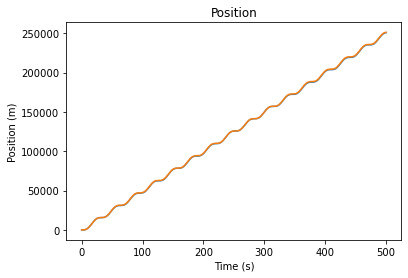

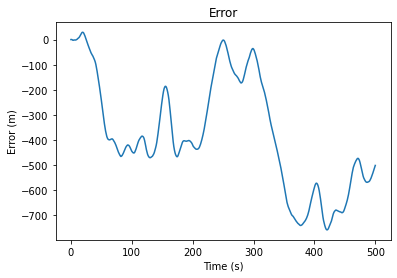

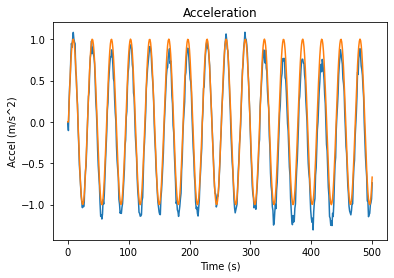

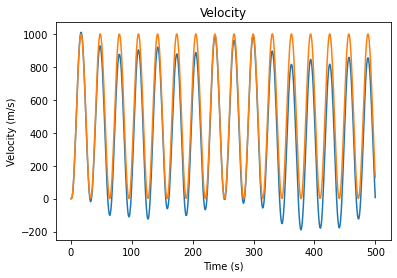

In [38]:
simulation = np.array(simulation, dtype=np.float32) # x, v, b, a, P1, P2
actual_simulation = np.array(actual_simulation, dtype=np.float32)
error = simulation[:,0] - actual_simulation[:,0]
Tf = np.linspace(0, T, T+1)

plt.figure(1)
plt.plot(Tf, simulation[:,0])
plt.plot(Tf, actual_simulation[:,0])
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position")

plt.figure(2)
plt.plot(Tf, error)
plt.xlabel("Time (s)")
plt.ylabel("Error (m)")
plt.title("Error")

plt.figure(3)
# plt.plot(Tf, simulation[:,3])
# plt.plot(Tf, actual_simulation[:,3])
plt.plot(Tf, simulation[:,2])
plt.plot(Tf, actual_simulation[:,2])
plt.xlabel("Time (s)")
plt.ylabel("Accel (m/s^2)")
plt.title("Acceleration")

plt.figure(4)
plt.plot(Tf, simulation[:,1])
plt.plot(Tf, actual_simulation[:,1])
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity")

Text(0.5, 1.0, 'Velocity Covariance')

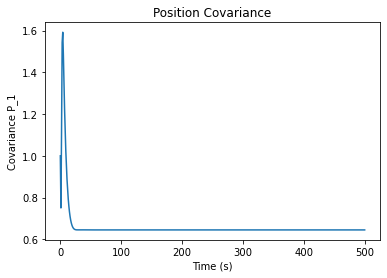

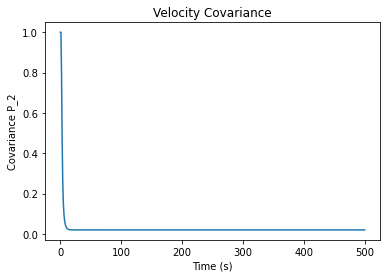

In [39]:
plt.figure(6)
plt.plot(Tf, simulation[:,3])
plt.xlabel("Time (s)")
plt.ylabel("Covariance P_1")
plt.title("Position Covariance")

plt.figure(7)
# plt.plot(Tf, simulation[:,5])
plt.plot(Tf, simulation[:,4])
plt.xlabel("Time (s)")
plt.ylabel("Covariance P_2")
plt.title("Velocity Covariance")
